# Sensitivity Analysis

Sensitivity analysis in a nutshell is determining the influence of input variables on a function. Around a single point, this can be computed as the partial derivatives of the function. This form is referred to as local sensitivity analysis. However to determine the influence of input variables across a domain on a function, you perform global sensitivity analysis also known as Hoeffding-Sobol or ANOVA decomposition.

In this notebook, I am using the in-built function for performing sensitivity analysis on emukit. Since, we don't know the form of the function that defines the relationship between our input variables (longitude, latitude, and time) and the output (precipitation), I am using a version of the function that allows us to determine the sensitivity of the variables from the output using an emulator.

Running this function generates two values - the sobol indices and total effects of each variable. The sobol indices represent the influence of each variable while marginalizing the rest while the total effects represent the influence of a variable alone and across all its interactions with other variables.

# Importing Dependencies and Data

In [2]:
import intake
import proplot as plot
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import cftime

In [3]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
dataframe = intake.open_esm_datastore(url)

models = dataframe.search(experiment_id="historical",
                         variable_id="pr",
                         institution_id="MOHC",
                         member_id="r1i1p1f2")

datasets = models.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [4]:
ds = datasets["CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn"]
df = ds.to_dataframe()

training_set = df.loc[df.index.get_level_values("time") <= cftime.Datetime360Day(1965, 6, 16, 0, 0, 0, 0, has_year_zero=True)]
test_set = df.loc[df.index.get_level_values("time") >= cftime.Datetime360Day(1982, 1, 16, 0, 0, 0, 0, has_year_zero=True)]

validation_set = df.loc[(df.index.get_level_values("time") > cftime.Datetime360Day(1965, 6, 16, 0, 0, 0, 0, has_year_zero=True)) & (df.index.get_level_values("time") < cftime.Datetime360Day(1982, 1, 16, 0, 0, 0, 0, has_year_zero=True))]

Using the training set, extract the data from the Tropics. Based on my readings, this area has higher variability in precipitation and therefore should be a somewhat accurate smaller representation of our dataset.

In [5]:
keys = training_set['pr'].keys()
band_a = []
for element in keys:
    if  element[0] >= -23.125 and element[0] <= 23.125  and element[1] == 0:
        band_a.append(element)
        
band_b = []
for element in keys:
    if  element[0] >= -23.125 and element[0] <= 23.125  and element[1] == 1:
        band_b.append(element)

In [6]:
training_band_a = pd.DataFrame.from_records(
    band_a, columns=['lat', 'band', 'lon', 'member_id', 'time'])
training_band_a = training_band_a.drop(columns=['band','member_id'])
training_band_a["time"] = [cftime.date2num(ind, "days since 1850-01-01") for ind in training_band_a["time"]]

In [7]:
x_train_a = training_band_a.to_numpy()
y_train_a = (np.array(training_set['pr'][band_a])*10**5)[:,np.newaxis]

In [8]:
x_train_a[300]

array([-2.3125e+01,  9.3750e-01,  9.0150e+03])

# Global Sensitivity Analysis using Output

Importing the Emukit modules for running the analysis, defining the domain of the input variables and running the analysis.

In [9]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.core import DiscreteParameter, ParameterSpace

In [10]:
time_domain = np.linspace(0, 1_000_000, 10)
lat_domain = np.linspace(-23.125, 23.125, 38)
lon_domain = np.linspace(0.9375, 359.0625, 192)

space = ParameterSpace([DiscreteParameter('lon', lon_domain), 
                        DiscreteParameter('lat', lat_domain),
                        DiscreteParameter('time', time_domain)])

In [13]:
model_gpy = GPRegression(x_train_a[:10000], y_train_a[:10000])
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [14]:
num_mc = 10000
senstivity_gpbased = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity_gpbased.compute_effects(num_monte_carlo_points = num_mc)

In [34]:
main_effects_gp

{'lon': array([-0.00566617]),
 'lat': array([-0.00709202]),
 'time': array([0.10918397])}

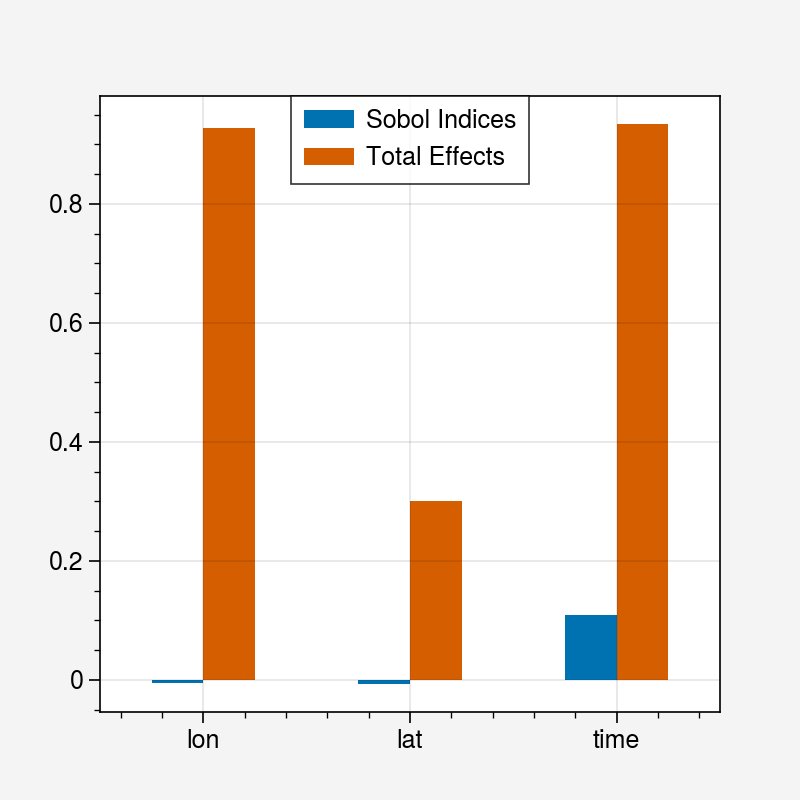

In [33]:
main_effects = [main_effects_gp['lon'][0], main_effects_gp['lat'][0], main_effects_gp['time'][0]]
total_effects = [total_effects_gp['lon'][0], total_effects_gp['lat'][0], total_effects_gp['time'][0]]
index = ['lon', 'lat', 'time']
df = pd.DataFrame({'Sobol Indices': main_effects,
                    'Total Effects': total_effects}, index=index)
ax = df.plot.bar(rot=0)